# Titanic Survivors (NN)

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.tabular import *

In [4]:
path = f'./data'

## DataFrames and Feature Engineering

Basic feature engineering taken from the kaggle examples provided

In [9]:
train_df = pd.read_csv(f'{path}/train.csv')
test_df = pd.read_csv(f'{path}/test.csv')

train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Pulled the following code from https://www.kaggle.com/abedkhooli/fastai-titanic to help deal with nulls so that I can add in my test set appropriately to the databunch later. Credit Abed Khooli.

In [14]:
# dealing with nulls
# 1 Fare in test_df (all_df[all_df['Fare'].isnull()]), use media = 14.55 from all_df.describe()
mask = test_df['Fare'].isnull()
test_df.loc[mask, 'Fare'] = 14.55
# 2 embarked in train_df (all_df[all_df['Embarked'].isnull()]) survived is not null, so train 
mask2 = train_df['Embarked'].isnull()
train_df.loc[mask2, 'Embarked'] = 'S'
# 263 ages, use median per sex: all_df.groupby('Sex').median()['Age'] => F 27, M: 28 
mask3 = (train_df['Age'].isnull()) & (train_df['Sex'] == 'female')
train_df.loc[mask3, 'Age'] = 27.0
mask4 = (train_df['Age'].isnull()) & (train_df['Sex'] == 'male')
train_df.loc[mask4, 'Age'] = 28.0
mask5 = (test_df['Age'].isnull()) & (test_df['Sex'] == 'female')
test_df.loc[mask5, 'Age'] = 27.0
mask6 = (test_df['Age'].isnull()) & (test_df['Sex'] == 'male')
test_df.loc[mask6, 'Age'] = 28.0

In [7]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    return np.nan


def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

In [15]:
for df in [train_df, test_df]:
    #replacing all titles with mr, mrs, miss, master
    df['Title']=df['Name'].map(lambda x: substrings_in_string(x, title_list))
    df['Title']=df.apply(replace_titles, axis=1)

    #Turning cabin number into Deck
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    df['Deck']=df['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))
    
    df['FamilySize']= 1 + df['SibSp'] + df['Parch']

## Data Bunch

In [19]:
dep_var = 'Survived'
cat_names = ['Pclass', 'Embarked', 'Sex', 'Title', 'Deck']
cont_names = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
procs = [FillMissing, Categorify, Normalize]

In [20]:
test = TabularList.from_df(test_df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)

In [21]:
data = (TabularList.from_df(train_df, path=path, cat_names=cat_names, cont_names = cont_names, procs=procs)
                   .split_by_idx(valid_idx=range(len(train_df)-175,len(train_df)))
                   .label_from_df(cols=dep_var)
                   .add_test(test, label=0)
                   .databunch())

## Training and Model Fit

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


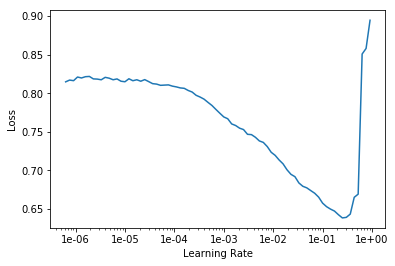

In [22]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 5e-2
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy
1,0.624091,0.550440,0.662857
2,0.547157,0.417812,0.822857
3,0.502208,0.334623,0.857143


In [13]:
learn.validate()

[0.34322262, tensor(0.8686)]

## Generate a Competition File

In [14]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

In [15]:
res_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': labels})
res_df.to_csv(f'{path}/titanic-submission.csv', index=False)